In [ ]:
下面我们开始尝试做图形的预处理。

图片旋转：
下面的代码，取自gnt-C.ipynb
http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate
    
    
    这个skimage： http://scikit-image.org/docs/dev/auto_examples/index.html
        
        感觉做图片的切分应该很合适。
        
        

../data/sandbox/03755
shape of images is:  (120, 64, 64)
sandbox:  120 54 [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
image_data:  [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


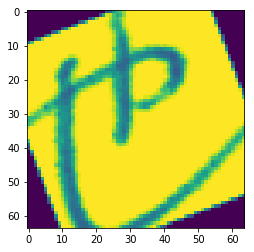

In [9]:
import os
import random
from PIL import *
from numpy import array
import numpy as np

IMAGE_SIZE = 64
CHARSET_SIZE = 3755

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.transform import rotate

class DataIterator:
    def __init__(self, data_dir):
        # Set FLAGS.charset_size to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print(truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        image_rotated = [rotate(image, np.random.random_sample()*90-45) for image in image_resized]
        self.images = [rgb2gray(item) for item in image_rotated]
        self.images = array(self.images)
        print ('shape of images is: ', self.images.shape)

    @property
    def size(self):
        return len(self.labels)
    
test_feeder = DataIterator(data_dir='../data/sandbox/')
print ('sandbox: ', test_feeder.size, test_feeder.labels[0], test_feeder.images[0])


# show image
import matplotlib.pyplot as plt
first_array=test_feeder.images[0]
image_data = first_array.reshape((IMAGE_SIZE, IMAGE_SIZE))
print ('image_data: ', image_data)


#Not sure you even have to do that if you just want to visualize it
#first_array=255*first_array
#first_array=first_array.astype("uint8")
plt.imshow(image_data)
#Actually displaying the plot if you are not in interactive mode
plt.show()

下面开始，对于加入左右随机旋转45度的汉字，进行训练：



In [5]:
import numpy as np

np.random.random_sample()*90-45

29.810517258499814

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.transform import rotate

IMAGE_SIZE = 64
FULL_CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def input(dataset):
    return dataset.images, dataset.labels

class DataSetLoader:
    def __init__(self, data_dir):
        # Set CHARSET_SIZE to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        image_rotated = [rotate(image, np.random.random_sample()*90-45) for image in image_resized]
        self.images = [rgb2gray(item) for item in image_rotated]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

# Build 2 layer DNN classifier
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[1024, 1024, 1024, 1024, 1024],
    optimizer=tf.train.AdamOptimizer(1e-4),
    n_classes=CHARSET_SIZE,
    dropout=0.1,
    model_dir="../dfs/checkpoint/dnn7_model_b"
)
for i in range(10):
    train_data = DataSetLoader(data_dir='../data/train_/')
    print ('Train data loaded for the %d times.'%(i+1))
    # Define the training inputs
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": input(train_data)[0]},
        y=input(train_data)[1],
        num_epochs=None,
        batch_size=50,
        shuffle=True
    )

    classifier.train(input_fn=train_input_fn, steps=2000)


print ('Train done, begin to test ...')
test_data = DataSetLoader(data_dir='../data/test_/')
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

# Evaluate accuracy
accuracy_score = classifier.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../dfs/checkpoint/dnn7_model_b', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
Now processing path:  ../data/train_/00037
Train data loaded for the 1 times.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_b/model.ckpt-24000
INFO:tensorflow:Saving checkpoints for 24001 into ../dfs/checkpoint/dnn7_model_b/model.ckpt.
INFO:tensorflow:loss = 25.8532, step = 24001
INFO:tensorflow:global_step/sec: 7.89835
INFO:tensorflow:loss = 25.9632, step = 24101 (12.667 sec)
INFO:tensorflow:global_step/sec: 7.65817
INFO:tensorflow:loss = 14.049, step = 24201 (13.054 sec)
INFO:tensorflow:global_step/sec: 7.15994
INFO:tensorflow:loss = 30.3948, step = 24301 (13.966 sec)


INFO:tensorflow:loss = 29.9558, step = 30501 (13.328 sec)
INFO:tensorflow:global_step/sec: 7.47321
INFO:tensorflow:loss = 21.8609, step = 30601 (13.382 sec)
INFO:tensorflow:global_step/sec: 7.57952
INFO:tensorflow:loss = 12.13, step = 30701 (13.194 sec)
INFO:tensorflow:global_step/sec: 7.55048
INFO:tensorflow:loss = 18.5135, step = 30801 (13.243 sec)
INFO:tensorflow:global_step/sec: 7.55848
INFO:tensorflow:loss = 13.3945, step = 30901 (13.231 sec)
INFO:tensorflow:global_step/sec: 7.61169
INFO:tensorflow:loss = 16.4063, step = 31001 (13.138 sec)
INFO:tensorflow:global_step/sec: 7.7875
INFO:tensorflow:loss = 19.7503, step = 31101 (12.841 sec)
INFO:tensorflow:global_step/sec: 7.87114
INFO:tensorflow:loss = 7.47633, step = 31201 (12.717 sec)
INFO:tensorflow:global_step/sec: 7.60528
INFO:tensorflow:loss = 5.50955, step = 31301 (13.138 sec)
INFO:tensorflow:global_step/sec: 7.51568
INFO:tensorflow:loss = 11.6992, step = 31401 (13.306 sec)
INFO:tensorflow:global_step/sec: 7.74778
INFO:tensorfl

下面开始测试：


In [4]:
# from: https://www.kaggle.com/jeffcarp/example-save-and-load-a-tensorflow-model

import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize

from tensorflow.contrib.learn.python.learn.estimators import run_config
from tensorflow.contrib.training.python.training import hparam

IMAGE_SIZE = 64
# CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def input(dataset):
    return dataset.images, dataset.labels

class DataSetLoader:
    def __init__(self, data_dir):
        # Set CHARSET_SIZE to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        self.images = [rgb2gray(item) for item in image_resized]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

def make_estimator(model_dir):
    config = run_config.RunConfig(model_dir=model_dir)

    return tf.estimator.DNNClassifier (
        config=config,
        feature_columns=feature_columns,
    hidden_units=[1024, 1024, 1024, 1024, 1024],
    optimizer=tf.train.AdamOptimizer(1e-4),
    n_classes=CHARSET_SIZE,
    dropout=0.1)
    

MODEL_DIR = "../dfs/checkpoint/dnn7_model_b"
model_from_checkpoint = make_estimator(MODEL_DIR)

test_data = DataSetLoader(data_dir='../data/test_/')
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    num_epochs=1,
    shuffle=False)

# Evaluate accuracy
accuracy_score = model_from_checkpoint.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f63e0750e80>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../dfs/checkpoint/dnn7_model_b'}
Now processing path:  ../data/test_/00037
INFO:tensorflow:Starting evaluation at 2018-04-21-10:07:22
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_b/model.ckpt-44000
INFO:tensorflow:Finished evaluation at 2018-04-21-10:07:24
INFO:tensorflow:Saving dict for global step 44000: accuracy = 0.745249, average_loss = 1.10402,

上面第一轮，约24000步时，精度为76%
```
INFO:tensorflow:Starting evaluation at 2018-04-21-08:54:21
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_b/model.ckpt-24000
INFO:tensorflow:Finished evaluation at 2018-04-21-08:54:24
INFO:tensorflow:Saving dict for global step 24000: accuracy = 0.762443, average_loss = 0.915754, global_step = 24000, loss = 112.434

Test Accuracy: 76.244342%
```

再来一轮20000步，看看有否长进。

再来2万步后，精度下降了：

INFO:tensorflow:Starting evaluation at 2018-04-21-10:07:22
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_b/model.ckpt-44000
INFO:tensorflow:Finished evaluation at 2018-04-21-10:07:24
INFO:tensorflow:Saving dict for global step 44000: accuracy = 0.745249, average_loss = 1.10402, global_step = 44000, loss = 135.549

Test Accuracy: 74.524885%


使用随机左右旋转45度以内的数据进行训练，分别进行了2万步。精度在第二轮时，下降了。第一轮约为76%，第二轮约为74%。

理论上，如果计算资源足够，将旋转和gamma校正应用于训练数据，应该会提高精度 - 前提是学习步骤要足够多- 如100万步。


学习步骤少的话，使用旋转可能会将模型转昏。